In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
pp_score = pd.read_csv(r'C:\Users\yzh\Desktop\Python\PointPredictive\lobel_afm_output_2.csv')
lb_score = pd.read_csv(r'C:\Users\yzh\Desktop\Python\PointPredictive\Lobel_Data_2_PointPredictive_3Columns_02222021.csv')

In [41]:
df = pd.merge(pp_score,lb_score,on='Application ID')
df = df[df['funded']==1]
#df = df[(df['Lobel_Score']<=249)&(df['Lobel_Score']>=200)]

df.corrwith(df['Lobel_Score'])

Application ID    0.103310
approved               NaN
funded                 NaN
chargeoff        -0.209340
epd_3mo          -0.040412
epd_4mo          -0.053990
epd_6mo          -0.089463
AFM_score        -0.384168
CLOSE_DATE        0.096766
Lobel_Score       1.000000
dtype: float64

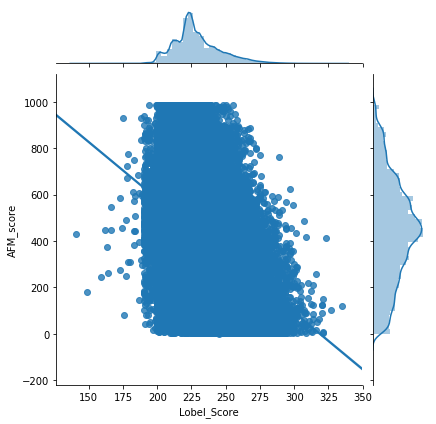

In [44]:
sns.jointplot(x=df["Lobel_Score"], y=df["AFM_score"], kind='reg')

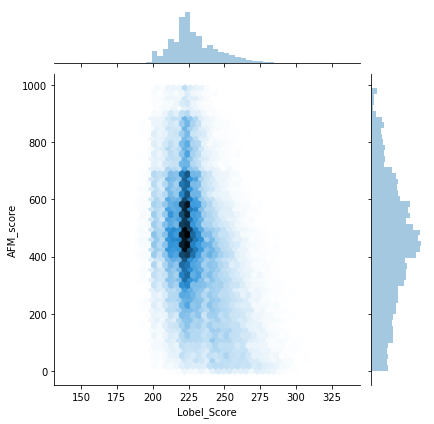

In [43]:
sns.jointplot(x=df["Lobel_Score"], y=df["AFM_score"], kind='hex')

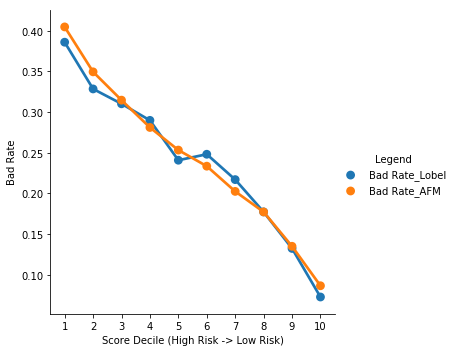

In [131]:
df['lb_score_bin'] = pd.qcut(df['Lobel_Score'],10)
df['afm_score_bin'] = pd.qcut(df['AFM_score'],10)

df['bad_rate'] = df['CLOSE_CODE'].isin(['CO','REPO','DPO'])
br = pd.pivot_table(df,index = 'afm_score_bin', columns = 'lb_score_bin', values = 'bad_rate', aggfunc=np.mean)
cnt = pd.pivot_table(df,index = 'afm_score_bin', columns = 'lb_score_bin',  aggfunc='size')

lb_br = df.groupby('lb_score_bin')['bad_rate'].agg(['mean','size'])
afm_br = df.groupby('afm_score_bin')['bad_rate'].agg(['mean','size'])
afm_br = afm_br.sort_index(ascending=False)

idx = list(range(1,11))
lb_idx_mapper = dict(zip(lb_br.index,idx))
afm_idx_mapper = dict(zip(afm_br.index, idx))

lb_br = lb_br.rename(index = lb_idx_mapper,columns = {'mean':'Bad Rate'})
afm_br = afm_br.rename(index = afm_idx_mapper,columns = {'mean':'Bad Rate'})

br_tbl = pd.merge(lb_br, afm_br, left_index = True, right_index = True, suffixes = ('_Lobel', '_AFM'))
br_tbl = br_tbl.reset_index()

br_tbl2 = br_tbl.melt(id_vars=['lb_score_bin'], value_vars=['Bad Rate_Lobel', 'Bad Rate_AFM'])
br_tbl2 = br_tbl2.rename(columns = {'lb_score_bin':'Score Decile (High Risk -> Low Risk)', 'value':'Bad Rate','variable':'Legend'})

g = sns.factorplot(x='Score Decile (High Risk -> Low Risk)', y='Bad Rate', hue='Legend', data=br_tbl2)

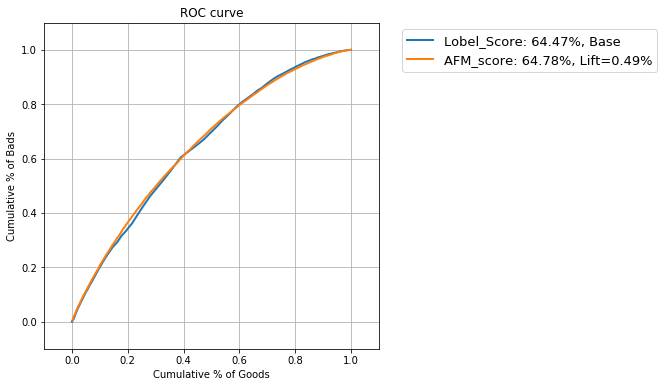

In [93]:
roc_plot(df, 'Target', 'Lobel_Score', 'AFM_score')

Text(0.5, 1.0, 'Bad Rate')

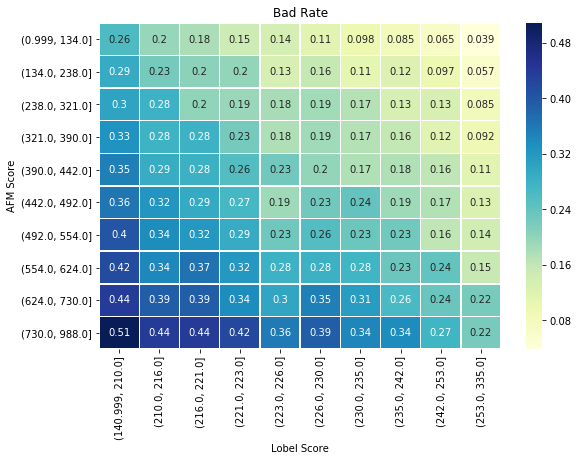

In [70]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(br, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
ax.set_xlabel('Lobel Score')
ax.set_ylabel('AFM Score')
plt.title('Bad Rate')

Text(0.5, 1.0, 'Count')

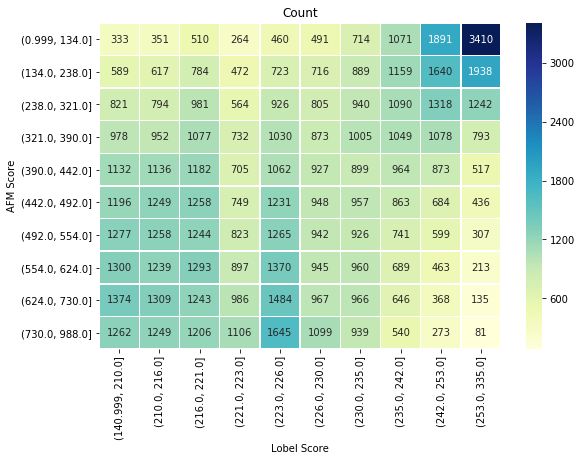

In [82]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cnt, annot=True,  linewidths=.5,fmt="d", ax=ax,cmap="YlGnBu")
ax.set_xlabel('Lobel Score')
ax.set_ylabel('AFM Score')
plt.title('Count')

In [92]:
def gb(target):
    if target in ['CO','REPO','DPO']:
        return 'BAD'
    elif target=='INS':
        return 'INDET'
    else: return 'GOOD'
    
df['Target'] = df['CLOSE_CODE'].apply(gb)

def roc_plot(df, target_name, *score_name):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df[target_name] = df[target_name].str.upper()
    df = df[(df[target_name] == 'GOOD') | (df[target_name] == 'BAD')]
    
    fig = plt.figure(figsize=(6,6))
    
    roc_lst = []
    
    for score in score_name:
        piv = df.pivot_table(df,index=score,columns=target_name,aggfunc='size',fill_value=0)
        if piv.index.min() == 1:     # if it's AFM Score, sort from high to low
            piv = piv.sort_index(ascending=False)
        else:                        # if it's first stage score, sort from low to high
            piv = piv.sort_index()
        piv['Bad%'] = (piv.BAD.cumsum(axis=0))/(piv.BAD.sum())
        piv['Good%'] = (piv.GOOD.cumsum(axis=0))/(piv.GOOD.sum())
        roc = (piv['Good%'] - piv['Good%'].shift(1)) * (piv['Bad%'] + piv['Bad%'].shift(1))/2   
        roc = sum(roc.replace(np.nan,0)) *100  
        roc_lst.append(roc)
        
        if len(roc_lst) == 1:
            plt.plot(piv['Good%'], piv['Bad%'], lw=2, label = "{}: {:.2f}%, Base".format(score, roc))
        else:
            lift = 100* (roc - roc_lst[0])/roc_lst[0]
            plt.plot(piv['Good%'], piv['Bad%'], lw=2, label = "{}: {:.2f}%, Lift={:.2f}%".format(score, roc,lift))
        
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('Cumulative % of Goods')
    plt.ylabel('Cumulative % of Bads')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(prop={'size':13}, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    
def lift(base_roc, new_roc):
    return (new_roc-base_roc)/base_roc

In [91]:
df.describe()

,Application ID,approved,funded,chargeoff,epd_3mo,epd_4mo,epd_6mo,AFM_score,CLOSE_DATE,Lobel_Score
count,9.466700e+04,94667.0,94667.0,94667.000000,94667.000000,94667.000000,94667.000000,94667.000000,4.180100e+04,94667.000000
mean,2.520466e+06,1.0,1.0,0.245629,0.016701,0.026641,0.053535,438.757825,2.019543e+07,229.174749
std,2.080740e+05,0.0,0.0,0.430462,0.128148,0.161032,0.225099,218.069656,7.128271e+03,17.108162
min,2.133345e+06,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,2.018013e+07,141.000000
25%,2.339280e+06,1.0,1.0,0.000000,0.000000,0.000000,0.000000,281.000000,2.019070e+07,219.000000
50%,2.516995e+06,1.0,1.0,0.000000,0.000000,0.000000,0.000000,442.000000,2.020012e+07,226.000000
75%,2.695712e+06,1.0,1.0,0.000000,0.000000,0.000000,0.000000,585.000000,2.020080e+07,238.000000
max,2.903443e+06,1.0,1.0,1.000000,1.000000,1.000000,1.000000,988.000000,2.021013e+07,335.000000
